In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\clean_data.csv")
cluster_df = pd.read_csv(r"C:\Users\tanzi\Personal Projects\cold_start_project_498r\data\clustered_time_patterns.csv")

In [4]:
# Merge cluster info into invocation-level data
if 'time_bucket' in df.columns and 'time_bucket' in cluster_df.columns:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'time_bucket', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek', 'time_bucket'], how='left')
else:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek'], how='left')

In [5]:
# Use minimal non-leaky features for realistic performance
clf_features = ['hour', 'dayofweek', 'is_weekend', 'cluster']
X = df[clf_features]
y = df['Cold_Start']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# No scaling needed here
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [8]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, None]
}
clf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, None],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [9]:

best_clf = gs.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

In [10]:

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2063
           1       0.56      0.63      0.59        63

    accuracy                           0.97      2126
   macro avg       0.77      0.81      0.79      2126
weighted avg       0.98      0.97      0.97      2126


Confusion Matrix:
 [[2031   32]
 [  23   40]]


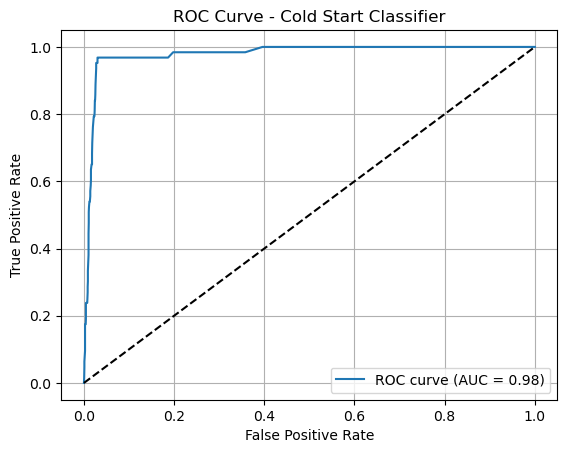

In [11]:
# ROC Curve
y_proba = best_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cold Start Classifier')
plt.legend()
plt.grid(True)
plt.show()

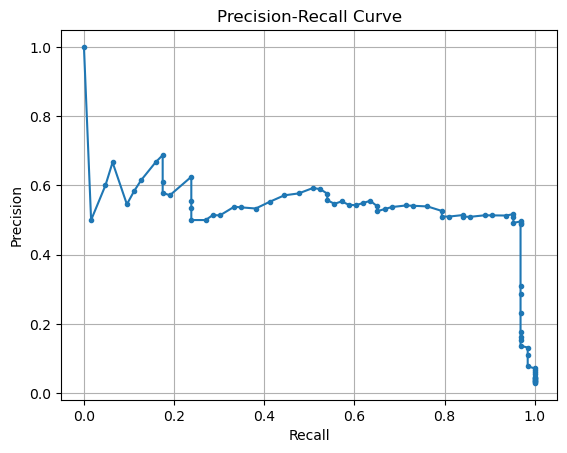

In [12]:

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [26]:
# Save classifier
joblib.dump(best_clf, '../models/cold_start_classifier.pkl')

['../models/cold_start_classifier.pkl']

In [28]:
# Error Analysis
errors = X_test_scaled.copy()
errors['true'] = y_test
errors['pred'] = y_pred
errors['proba'] = y_proba
print("\n❌ Misclassified samples:")
print(errors[errors['true'] != errors['pred']].head())


❌ Misclassified samples:
       hour  dayofweek  is_weekend  cluster  true  pred     proba
5275      6          0           0        0     0     1  0.563074
5199     23          6           1        0     0     1  0.605491
8005      2          1           0        0     0     1  0.556627
10576    16          2           0        2     1     0  0.001956
5190     22          6           1        0     1     0  0.477836


In [30]:
# --- Regression Task: Predict Delay ---
print("\n🔍 Regression: Predicting Delay")
reg_features = ['cold_start_ratio', 'total_invocations', 'cluster', 'anomaly_flag', 'cold_start_prob_est']
Xr = df[reg_features]
yr = df['Delay (s)']


🔍 Regression: Predicting Delay


In [32]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42)


In [34]:
scaler = StandardScaler()
Xr_train_scaled = Xr_train.copy()
Xr_test_scaled = Xr_test.copy()
Xr_train_scaled[['cold_start_ratio', 'total_invocations']] = scaler.fit_transform(Xr_train[['cold_start_ratio', 'total_invocations']])
Xr_test_scaled[['cold_start_ratio', 'total_invocations']] = scaler.transform(Xr_test[['cold_start_ratio', 'total_invocations']])

In [36]:
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
reg.fit(Xr_train_scaled, yr_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
yr_pred = reg.predict(Xr_test_scaled)

In [40]:
print("\n✅ RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))
print("✅ MAE:", mean_absolute_error(yr_test, yr_pred))



✅ RMSE: 1169.9061974144556
✅ MAE: 47.174008281188314


In [42]:
joblib.dump(reg, '../models/delay_predictor.pkl')

['../models/delay_predictor.pkl']